# load snps from vcf files

In [1]:
import allel
from os import path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData


data_dir = '/cellar/users/hsher/Data/popgen'
fname = "ALL.TGP_HGDP.GRCh37.bi.sorted.fixref.phased.isec.geno.23andMe.200-100-0.1_pairwise_SS.vcf.gz"  ## merged with Simon's genotypes
tabix = '/cellar/users/hsher/bin/samtools-1.10/htslib-1.10/tabix'
info = allel.read_vcf(path.join(data_dir, fname),log=sys.stdout)



[read_vcf] 65536 rows in 22.42s; chunk in 22.42s (2922 rows/s); 17 :9325819
[read_vcf] 74590 rows in 26.06s; chunk in 3.64s (2487 rows/s)
[read_vcf] all done (2861 rows/s)


In [2]:
sample = info['samples'] # sample ID

In [3]:
sample

array(['sfc_23andme', 'syn_23andme', 'HGDP01201', ..., 'NA21142',
       'NA21143', 'NA21144'], dtype=object)

In [4]:
#to genotype array
gt = allel.GenotypeArray(info['calldata/GT'], dtype = 'i1')
gt = gt.to_n_alt(fill = -1)

# In this dataset we have 527 snps, 3434 individuals

In [5]:
non_missing = np.where(np.sum(gt == -1, axis = 1) == 0)[0]

In [6]:
gt = gt[non_missing, :]

In [7]:
gt.shape

(74590, 3435)

# load metadata

In [8]:
# read 
sample_info = pd.read_pickle(path.join(data_dir,'sample_info.pickle'))
# add Shaun
df2 = pd.DataFrame([['Sheng-Yong Niu','Sheng-Yong Niu','M','23andme'], ['Shang-Fu Chen','Shang-Fu Chen','M','23andme']], columns=list(sample_info.columns), index = ['syn_23andme','sfc_23andme'])
sample_info = sample_info.append(df2)

In [9]:
# to use scanpy, everything has to go into AnnData, see https://anndata.readthedocs.io/en/stable/anndata.AnnData.html
adata = AnnData(X = gt.T, obs = sample_info.loc[sample])


In [10]:
# every other low dimensional visualization is based on PCA; pca is already slow for 15000 snps
sc.tl.pca(adata)


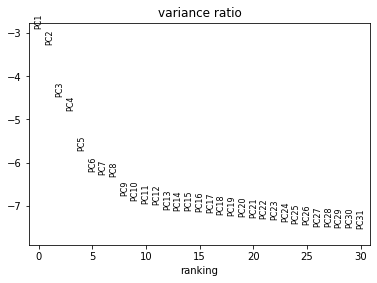

In [11]:
sc.pl.pca_variance_ratio(adata, log=True)

In [12]:
# use nearest neighbor way to fill -1 entry
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8)


/cellar/users/hsher/miniconda3/envs/popgen/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [13]:

sc.tl.draw_graph(adata, layout = 'fr')
sc.tl.umap(adata)
sc.tl.tsne(adata)


/cellar/users/hsher/miniconda3/envs/popgen/lib/python3.7/importlib/__init__.py:127: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  return _bootstrap._gcd_import(name[level:], package, level)
/cellar/users/hsher/miniconda3/envs/popgen/lib/python3.7/site-packages/umap/spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):
/cellar/users/hsher/miniconda3/envs/popgen/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning

... storing 'pop' as categorical
... storing 'super_pop' as categorical
... storing 'gender' as categorical
... storing 'batch' as categorical


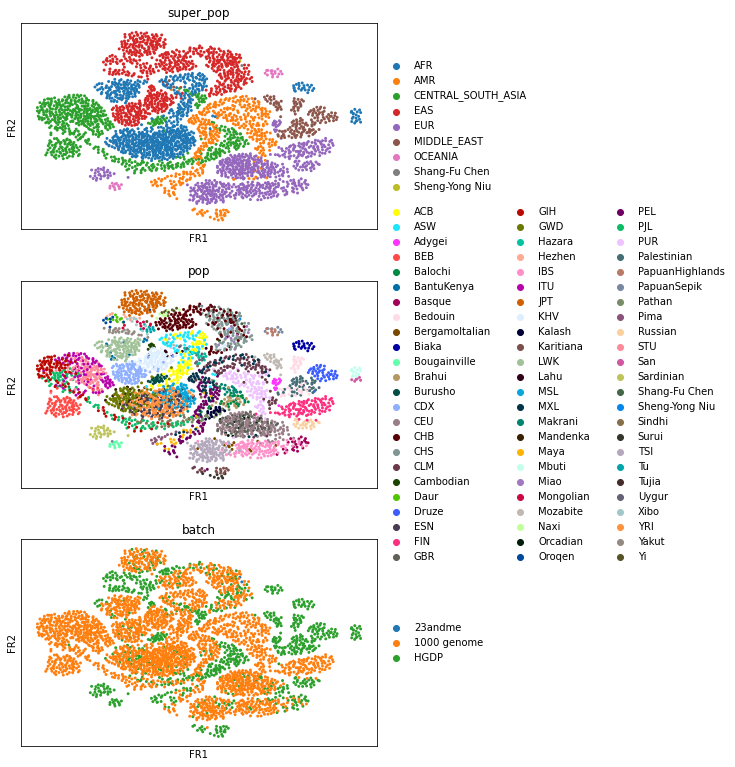

In [14]:
sc.pl.draw_graph(adata, color = ['super_pop','pop', 'batch'], legend_loc = 'right margin', ncols = 1)

# customize color
# load custom colors
from custome_color import *
super_pop_color['Shang-Fu Chen'] = 'black'
pop_to_color['Shang-Fu Chen'] = 'black'
super_pop_color['Sheng-Yong Niu'] = 'black'
pop_to_color['Sheng-Yong Niu'] = 'black'
adata.uns['super_pop_colors'] = adata.obs['super_pop'].cat.categories.map(super_pop_color)
adata.uns['pop_colors'] = adata.obs['pop'].cat.categories.map(pop_to_color)

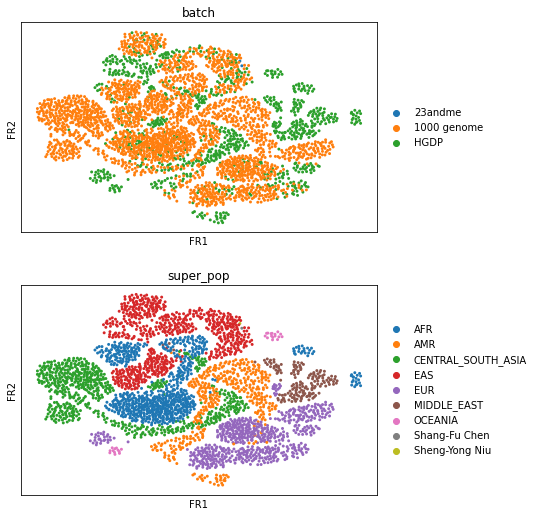

In [29]:
sc.pl.draw_graph(adata, color = ['batch', 'super_pop'], alpha = 1, ncols = 1)

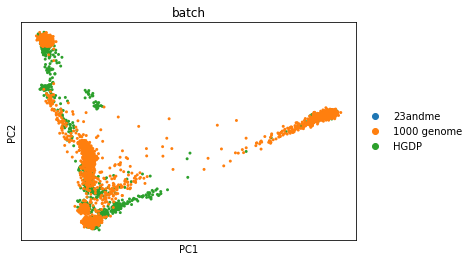

In [26]:
sc.pl.pca(adata, color = ['batch'], alpha = 1)

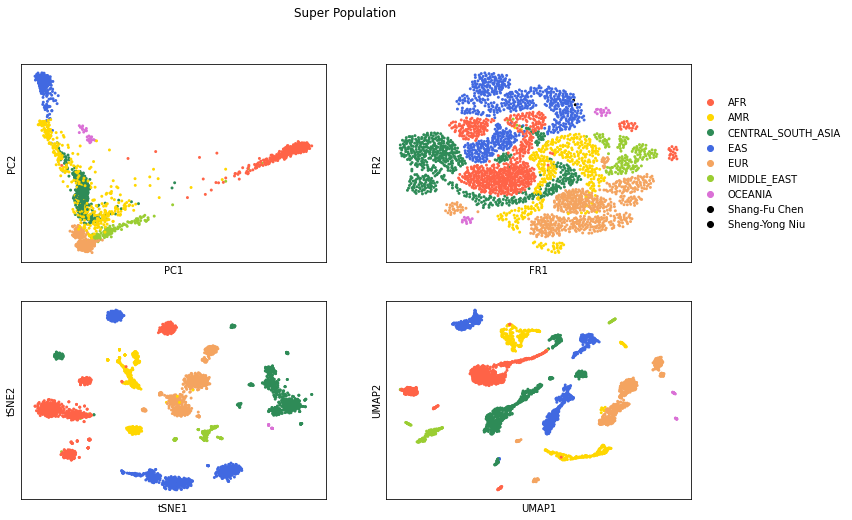

In [16]:
# superpop
f, ax = plt.subplots(2,2, figsize = (12,8))
ax = ax.flatten()
sc.pl.pca(adata, color = ['super_pop'], legend_loc = None, ax = ax[0], show = False)
sc.pl.draw_graph(adata, color = ['super_pop'], ax = ax[1], show = False, legend_loc = 'right margin')
sc.pl.tsne(adata, color = ['super_pop'],  ax = ax[2], show = False, legend_loc = None)
sc.pl.umap(adata, color = ['super_pop'],  ax = ax[3], show = False, legend_loc = None)
_ = [a.set_title('') for a in ax]
plt.suptitle("Super Population")
plt.show()


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

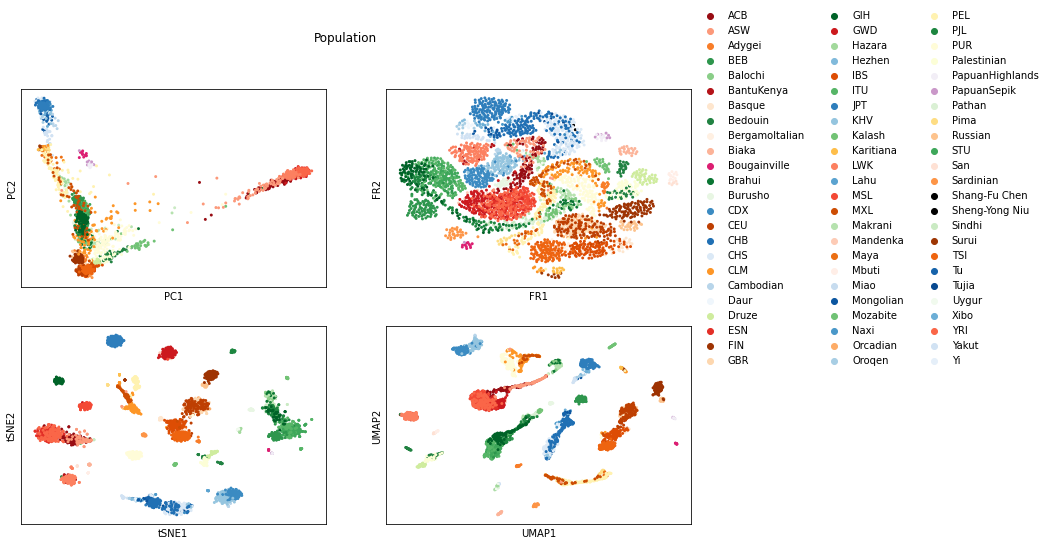

In [17]:
# superpop
f, ax = plt.subplots(2,2, figsize = (12,8))
ax = ax.flatten()
sc.pl.pca(adata, color = ['pop'], legend_loc = None, ax = ax[0], show = False)
sc.pl.draw_graph(adata, color = ['pop'], ax = ax[1], show = False, legend_loc = 'right margin')
sc.pl.tsne(adata, color = ['pop'],  ax = ax[2], show = False, legend_loc = None)
sc.pl.umap(adata, color = ['pop'],  ax = ax[3], show = False, legend_loc = None)
_ = [a.set_title('') for a in ax]
plt.suptitle("Population")
plt.show()


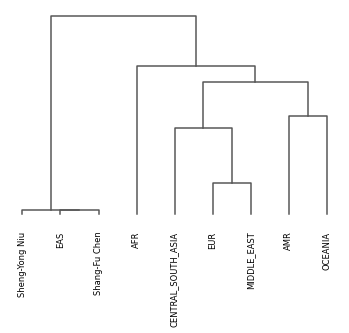

In [18]:
sc.tl.dendrogram(adata, groupby='super_pop')
sc.pl.dendrogram(adata, groupby='super_pop')
# sc.pl.dotplot(adata, groupby='louvain', dendrogram=True)

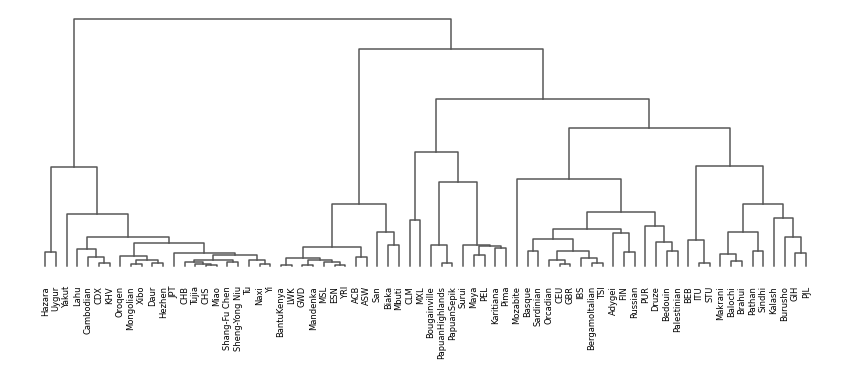

In [19]:
sc.tl.dendrogram(adata, groupby='pop')
_, axs = plt.subplots(ncols=1, figsize=(15, 5))
sc.pl.dendrogram(adata, groupby='pop', ax = axs)
# sc.pl.dotplot(adata, groupby='louvain', dendrogram=True)

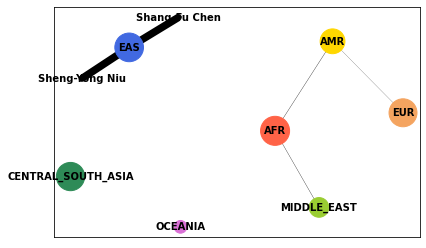

In [20]:
# do PAGA
sc.tl.paga(adata, groups='super_pop')
sc.pl.paga(adata, color=['super_pop'], max_edge_width = 10, node_size_scale= 4)

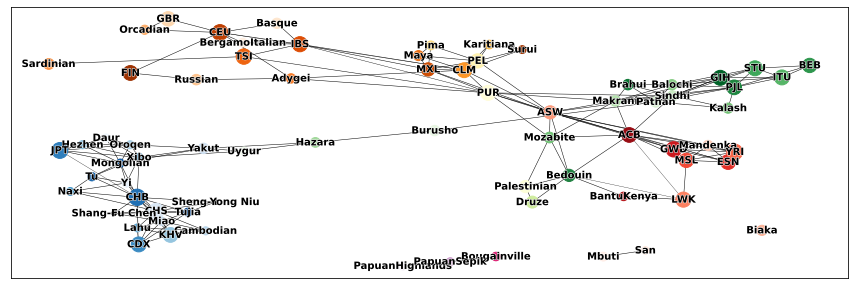

In [21]:
# do PAGA
_, axs = plt.subplots(ncols=1, figsize=(15, 5))
sc.tl.paga(adata, groups='pop', )
sc.pl.paga(adata, color=['pop'], max_edge_width = 0.5, node_size_scale= 1, layout = 'fr', ax = axs, fontoutline = 1)

# save file for later analysis

In [22]:
adata.uns['super_pop_colors'] = [] # these cannot be written into h5ad
adata.uns['pop_colors'] = []
adata.write(path.join(data_dir, 'par_knn_final.h5ad'))